In [112]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jaini\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jaini\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [113]:
# import libraries
import pandas as pd
import numpy as np
import re

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [114]:
# import data
data = pd.read_csv("D:/D/Machine Learning/data/TTC/ttc-bus-delay-data-2022.csv")
data.head(10)

,Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Direction,Vehicle
0,1-Jan-22,320,02:00,Saturday,YONGE AND DUNDAS,General Delay,0,0,NaN,8531
1,1-Jan-22,325,02:00,Saturday,OVERLEA AND THORCLIFFE,Diversion,131,161,W,8658
2,1-Jan-22,320,02:00,Saturday,YONGE AND STEELES,Operations - Operator,17,20,S,0
3,1-Jan-22,320,02:07,Saturday,YONGE AND STEELES,Operations - Operator,4,11,S,0
4,1-Jan-22,320,02:13,Saturday,YONGE AND STEELES,Operations - Operator,4,8,S,0
5,1-Jan-22,363,02:16,Saturday,KING AND SHAW,Operations - Operator,30,60,NaN,0
6,1-Jan-22,96,02:18,Saturday,HUMBERLINE LOOP,Security,0,0,N,3536
7,1-Jan-22,320,02:38,Saturday,STEELES AND YONGE,Operations - Operator,4,8,NaN,0
8,1-Jan-22,320,02:55,Saturday,YONGE AND STEELES,Operations - Operator,4,8,NaN,0
9,1-Jan-22,300,03:18,Saturday,KENNEDY STATION,Emergency Services,0,0,E,8094


In [115]:
# got data discription
data.describe()

,Min Delay,Min Gap,Vehicle
count,27351.000000,27351.000000,27351.000000
mean,20.298417,32.876714,5410.169427
std,49.636736,51.293913,4616.285325
min,0.000000,0.000000,0.000000
25%,9.000000,17.000000,1394.000000
50%,11.000000,22.000000,7940.000000
75%,20.000000,36.000000,8523.000000
max,999.000000,999.000000,93561.000000


In [116]:
data.dtypes

Date         object
Route        object
Time         object
Day          object
Location     object
Incident     object
Min Delay     int64
Min Gap       int64
Direction    object
Vehicle       int64
dtype: object

In [117]:
# Got null values in dataset
data = data.dropna()
data.isnull().sum()
len(data)

21735

In [118]:
# Seperate dates
from datetime import datetime

data['Date'] = pd.to_datetime(data['Date'], format='%d-%b-%y')
data['day'] = data['Date'].dt.day
data['month'] = data['Date'].dt.month
data['year'] = data['Date'].dt.year

data = data.drop('Date', axis=1)


In [119]:
# handle time formate
data['Time'] = pd.to_datetime(data['Time'], format = '%H:%M')
data['Hour'] = data['Time'].dt.hour
data['Minutes'] = data['Time'].dt.minute
data = data.drop('Time', axis=1)


In [120]:
# cleaning text
column_with_obj = ['Day', 'Location', 'Incident', 'Direction']

# Normalize of text
for i in column_with_obj:
    data[i] = data[i].str.lower()
    data[i] = data[i].str.strip()

# Remove noise (punctuation)
for i in column_with_obj:
    data[i] = data[i].str.replace(r'[^\w\s]', '', regex=True)

# performing stop word
stop_word = set(stopwords.words('english'))
def remove_stopword(txt):
    word_token = word_tokenize(str(txt).lower())
    flt = [word for word in word_token if word.isalpha() and word not in stop_word]
    return " ".join(flt)

l = len(data['Day'])

for i in column_with_obj:
    data[i] = data[i].apply(remove_stopword)


In [121]:
# Label encoding 
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

label = preprocessing.LabelEncoder()
column_with_obj = list(data.select_dtypes(include='object'))
for i in column_with_obj:
    data[i] = label.fit_transform(data[i])

data.head(5)
data.columns

Index(['Route', 'Day', 'Location', 'Incident', 'Min Delay', 'Min Gap',
       'Direction', 'Vehicle', 'day', 'month', 'year', 'Hour', 'Minutes'],
      dtype='object')

In [122]:
data.head(5)

,Route,Day,Location,Incident,Min Delay,Min Gap,Direction,Vehicle,day,month,year,Hour,Minutes
1,79,2,3337,3,131,161,6,8658,1,1,2022,2,0
2,76,2,4965,10,17,20,0,0,1,1,2022,2,0
3,76,2,4965,10,4,11,0,0,1,1,2022,2,7
4,76,2,4965,10,4,8,0,0,1,1,2022,2,13
6,203,2,1845,12,0,0,4,3536,1,1,2022,2,18


In [123]:
# split the data
# Prepare data for model
from sklearn.model_selection import train_test_split, cross_val_score
scale = preprocessing.StandardScaler()

X = data.drop(columns='Min Delay', axis=1)
X = preprocessing.scale(X)
y = data['Min Delay']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.17, random_state=42)

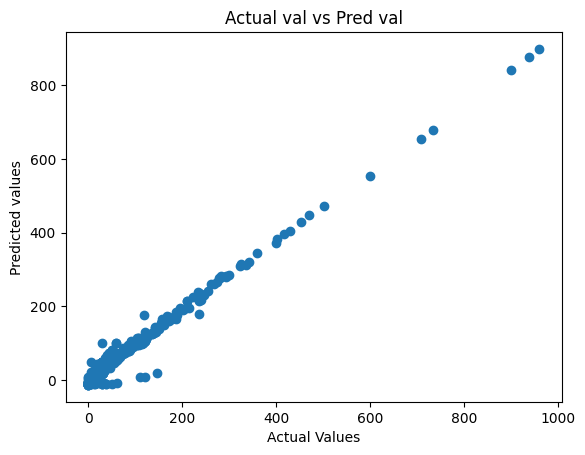

{'R2 Error': 0.9674052527749982, 'RMSE': np.float64(8.517602167951136)}

In [124]:
# Linear regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

def linear_regression():
    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    r2_error= r2_score(y_test, y_pred)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))

    # Making a visualization of prediction vs actual values for better understanding
    plt.scatter(y_test, y_pred)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted values")
    plt.title("Actual val vs Pred val")
    plt.show()

    return{
        'R2 Error': r2_error,
        'RMSE': RMSE
    }

linear_regression()

0.9860243826062568
0.9751260038681845


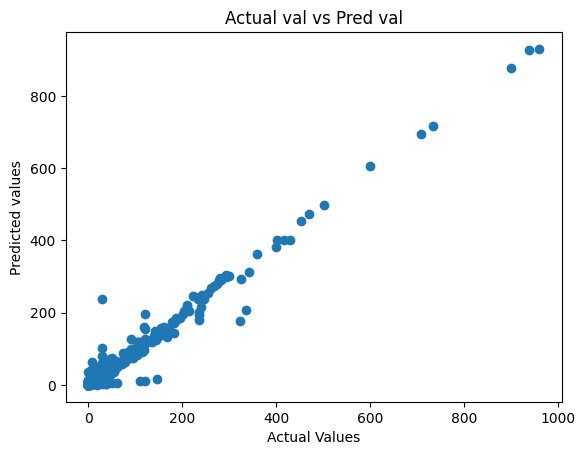

{'R2 Error': 0.9751260038681845, 'RMSE': np.float64(7.440743337013256)}

In [125]:
# Random forest regressor model
from sklearn.ensemble import RandomForestRegressor

def random_forest_regressor():
    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2_error= r2_score(y_test, y_pred)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))

    train_score = model.score(X_train, y_train)
    test_Score = model.score(X_test, y_test)

    print(train_score)
    print(test_Score)

    # Making a visualization of prediction vs actual values for better understanding
    plt.scatter(y_test, y_pred)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted values")
    plt.title("Actual val vs Pred val")
    plt.show()

    return{
        'R2 Error': r2_error,
        'RMSE': RMSE
    }

random_forest_regressor()